Imports

In [0]:
import io
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load Data

In [47]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Add alpha, beta

** Not sure if this step necessary **

In [49]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NetworkingAI/aggData.csv')
df['alpha'] = (df['thput']/(df['thput']+df['rsrp']))
df['beta'] = (df['rsrp']/(df['thput']+df['rsrp']))
df.head(2)

,timestamp,resolution,playback_mode,buffer,rsrp,thput,alpha,beta
0,2019-09-21 13:58:00.000,1,1,4.214899,-104.0,24804,1.004211,-0.004211
1,2019-09-21 13:58:01.011,1,1,4.457133,-104.0,12402,1.008457,-0.008457


Grab "rsrp" and "buffer" for input features

Using time series data and "rsrp" to predict "buffer"

In [34]:
input_features = df.iloc[:,[4,3]].values
input_data = input_features
input_data

array([[-104.      ,    4.214899],
       [-104.      ,    4.457133],
       [-104.      ,    7.855983],
       ...,
       [-106.      ,   49.016383],
       [-106.      ,   48.007071],
       [-106.      ,   46.996016]])

Normalize the input data so all input features on scale from 0 to 1

In [35]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_features[:,:])
input_data

array([[3.35276100e-08, 5.66200447e-02],
       [3.35276100e-08, 5.85258453e-02],
       [3.35276100e-08, 8.52666430e-02],
       ...,
       [3.16649650e-08, 4.09100272e-01],
       [3.16649650e-08, 4.01159408e-01],
       [3.16649650e-08, 3.93204830e-01]])

Consider data from the previous 50 days

Take 30% of latest data for test dataset

In [0]:
# t contains [rsrp, thput] time series data of length 50
# x contains each t
# y contains thput time series data ahead of lookback

lookback = 50

test_size=int(.3 * len(df))
x=[]
y=[]
for i in range(len(df)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    x.append(t)
    y.append(input_data[i+ lookback,1])

LSTM expects the input data in a specific 3D format of (test sample size, time steps, number of input features).

In our case timesteps is 50 and number of input features is 2 (rsrp and buffer).

Convert input data X into an array and then use reshape() to convert to the specified 3D format.

In [37]:
x, y = np.array(x), np.array(y)
x_test = x[:test_size+lookback]
x = x.reshape(x.shape[0], lookback, 2)
x_test = x_test.reshape(x_test.shape[0], lookback, 2)
print(x.shape)
print(x_test.shape)

(17736, 50, 2)
(5386, 50, 2)


Build the RNN LSTM model

30 RNN cells stacked one after the other in the RNN, implementing an efficient stacked RNN.

return_sequences = True to return the last output in the output sequence.

input_shape will be of the 3D format of (sample size, time steps, no. of input features).

Output will have only one unit as this is a regression problem.

In [38]:
from keras import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(x.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


Compile the model using adam optimizer and loss function MSE for the regression problem.

Fit the model using a batch_size of 32 and 200 epochs.

In [39]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x, y, epochs=3, batch_size=32)

Epoch 1/3
17736/17736 [==============================] - 153s 9ms/step - loss: 0.0100
Epoch 2/3
17736/17736 [==============================] - 151s 8ms/step - loss: 0.0036
Epoch 3/3
17736/17736 [==============================] - 152s 9ms/step - loss: 0.0031


Save the model

In [0]:
predicted_value = model.predict(x_test)

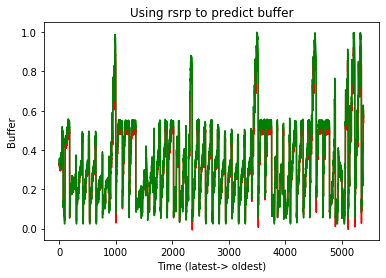

In [42]:
plt.plot(predicted_value, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Using rsrp to predict buffer")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Buffer")
plt.show()

In [43]:
obs = input_data[lookback:test_size+(2*lookback),1] 
mse = (np.square(obs - predicted_value)).mean(axis=None)
mse

0.0776729683122451

In [56]:
!mkdir ./temp
!git clone "https://github.com/dweinflash/NetworkingAI.git" ./temp
!rsync -aP --exclude=data/ "/content/drive/My Drive/Colab Notebooks/NetworkingAI"/* ./temp

%cd ./temp
!git add .
!git commit -m '"first"'
!git config --global user.email "david.weinflash@gmail.com"
!git config --global user.name "dweinflash"
!git push origin "master"
%cd /content
!rm -rf ./temp

Cloning into './temp'...
sending incremental file list
293N.ipynb
         76,479 100%   41.69MB/s    0:00:00 (xfr#1, to-chk=183/184)
aggData.csv
        881,127 100%  168.06MB/s    0:00:00 (xfr#2, to-chk=182/184)
NetworkingAI/
NetworkingAI/.git/
NetworkingAI/.git/HEAD
             23 100%    3.74kB/s    0:00:00 (xfr#3, to-chk=178/184)
NetworkingAI/.git/config
            289 100%   47.04kB/s    0:00:00 (xfr#4, to-chk=177/184)
NetworkingAI/.git/description
             73 100%   10.18kB/s    0:00:00 (xfr#5, to-chk=176/184)
NetworkingAI/.git/branches/
NetworkingAI/.git/hooks/
NetworkingAI/.git/hooks/applypatch-msg.sample
            478 100%   58.35kB/s    0:00:00 (xfr#6, to-chk=170/184)
NetworkingAI/.git/hooks/commit-msg.sample
            896 100%  109.38kB/s    0:00:00 (xfr#7, to-chk=169/184)
NetworkingAI/.git/hooks/fsmonitor-watchman.sample
          3,327 100%  361.00kB/s    0:00:00 (xfr#8, to-chk=168/184)
NetworkingAI/.git/hooks/post-update.sample
            189 100%   20.51kB/s 

**Future iterations:**

*   Save model checkpoints
*   Integrate GitHub
*   Increase epochs
*   Increase lookback
*   Use thput to predict buffer
*   Use both thput/rsrp to predict buffer
*   Use alpha to predict buffer
*   Use beta to predict buffer

**Video Quality Comparison**

Tool set for comparing two videos

How similar/different are they in quality?

OpenCV toolset? MatLab toolset?

Just a comparison problem - no ML

Derive the correlation between the two videos. Need to make your own unified metric?

Trouble with syncing up the start times of both videos

Comparison of two different video qualities

Sync up the videos so they start at the same frame

Source vs Output files

How similar is output file to source file?